In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf
import os
from keras import objectives
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input,Model,layers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import *


Using TensorFlow backend.


In [2]:
# 将图片进行二值化处理

def adjustData(img,mask,gen):
    img = img / 255
    mask = mask /255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0
    gen = gen /255
    gen[gen > 0.5] = 1
    gen[gen <= 0.5] = 0
    return (img,mask,gen)
def trainGenerator(batch_size,train_path,aug_dict,
                   image_save_prefix  = "image",mask_save_prefix  = "mask",
                   save_to_dir = None,target_size = (256,256),seed = 1):
    '''
    可以不断地同时产生image和mask
    使用相同的seed确保到image_datagen和mask_datagen对图片的扩充是对应的
    '''
    # 两个生成器，aug_dict指定了如何扩充
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    gen_datagen = ImageDataGenerator(**aug_dict)
    
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = ["image"],
        class_mode = None,
        color_mode = "grayscale",
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
         train_path,
        classes = ["label"],
        class_mode = None,
        color_mode = "grayscale",
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    
    gen_generator = gen_datagen.flow_from_directory(
        train_path,
        classes = ["predict"],
        class_mode = None,
        color_mode = "grayscale",
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator,gen_generator)
    # img.shape == (batch_size,target_szie[0],arget_szie[1],1)
    for (img,mask,gen) in train_generator:
        img,mask,gen = adjustData(img,mask,gen)
        yield (img,mask,gen)


In [3]:
data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                    fill_mode='nearest')
myGene = trainGenerator(1,'data/membrane/train/',data_gen_args,save_to_dir = None)


In [4]:
loss_object = tf.keras.losses.BinaryCrossentropy()
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4)

In [5]:
def make_discriminator_model():
    k=3 # kernel size
    s=2 # stride
    n_filters = 64
    padding='same'#'valid
    name ="d"
    inp = tf.keras.layers.Input(shape=[256, 256, 1], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 1], name='target_image')
    inp1 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(inp)
    tar1 = Conv2D(64, 3, padding = 'same', kernel_initializer = 'he_normal')(tar)
    
    
    x = tf.keras.layers.concatenate([inp1, tar1]) 
    conv1 = Conv2D(n_filters, kernel_size=(k, k), strides=(s,s), padding=padding)(x)
    conv1 = BatchNormalization(scale=False, axis=3)(conv1)
    conv1 = Activation('relu')(conv1)    
    conv1 = Conv2D(n_filters, kernel_size=(k, k), padding=padding)(conv1) 
    conv1 = BatchNormalization(scale=False, axis=3)(conv1)
    conv1 = Activation('relu')(conv1)    
    pool1 = MaxPooling2D(pool_size=(s, s))(conv1)
    
    conv2 = Conv2D(2*n_filters, kernel_size=(k, k), strides=(s,s), padding=padding)(pool1) 
    conv2 = BatchNormalization(scale=False, axis=3)(conv2)
    conv2 = Activation('relu')(conv2)    
    conv2 = Conv2D(2*n_filters, kernel_size=(k, k), padding=padding)(conv2) 
    conv2 = BatchNormalization(scale=False, axis=3)(conv2)
    conv2 = Activation('relu')(conv2)    
    pool2 = MaxPooling2D(pool_size=(s, s))(conv2)
    
    conv3 = Conv2D(4*n_filters, kernel_size=(k, k), padding=padding)(pool2) 
    conv3 = BatchNormalization(scale=False, axis=3)(conv3)
    conv3 = Activation('relu')(conv3)    
    conv3 = Conv2D(4*n_filters, kernel_size=(k, k), padding=padding)(conv3) 
    conv3 = BatchNormalization(scale=False, axis=3)(conv3)
    conv3 = Activation('relu')(conv3)    
    pool3 = MaxPooling2D(pool_size=(s, s))(conv3)
    
    conv4 = Conv2D(8*n_filters, kernel_size=(k, k), padding=padding)(pool3) 
    conv4 = BatchNormalization(scale=False, axis=3)(conv4)
    conv4 = Activation('relu')(conv4)    
    conv4 = Conv2D(8*n_filters, kernel_size=(k, k), padding=padding)(conv4) 
    conv4 = BatchNormalization(scale=False, axis=3)(conv4)
    conv4 = Activation('relu')(conv4)    
    pool4 = MaxPooling2D(pool_size=(s, s))(conv4)
    
    conv5 = Conv2D(16*n_filters, kernel_size=(k, k), padding=padding)(pool4) 
    conv5 = BatchNormalization(scale=False, axis=3)(conv5)
    conv5 = Activation('relu')(conv5)    
    conv5 = Conv2D(16*n_filters, kernel_size=(k, k), padding=padding)(conv5) 
    conv5 = BatchNormalization(scale=False, axis=3)(conv5)
    conv5 = Activation('relu')(conv5)
    
    gap=GlobalAveragePooling2D()(conv5)
    outputs=Dense(1, activation='sigmoid')(gap)
    
    d = Model([inp,tar], outputs, name=name)


    d.compile(optimizer=Adam(lr=0.0001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
    return d

In [6]:
@tf.function
def train_step(img, mask, predict,discriminator):
    with tf.GradientTape() as tape:
        disc_real_output = discriminator([img, mask], training=True)
        disc_generated_output = discriminator([img, predict], training=True)
        real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
        generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
        total_loss = real_loss + generated_loss
    discriminator_gradients = tape.gradient(total_loss,discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

In [7]:
def fit(epochs, myGene,steps,discriminator):
  for epoch in range(epochs):
    step = 0
    for img_mask_predict_tuple in myGene:
        step += 1
        img = img_mask_predict_tuple[0]
        mask = img_mask_predict_tuple[1]
        predict = img_mask_predict_tuple[2]
        train_step(img, mask, predict, discriminator)
        
        if(step > steps):
            print("训练完成")
            break
        if(step % 20 == 0):
            print("已经完成：",step)

In [8]:
discriminator = make_discriminator_model()
fit(1, myGene , 1000 ,discriminator)

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.


W1204 09:49:15.299447 139894255765312 deprecation.py:323] From /home/hadoop/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:182: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


已经完成： 20
已经完成： 40
已经完成： 60
已经完成： 80
已经完成： 100
已经完成： 120
已经完成： 140
已经完成： 160
已经完成： 180
已经完成： 200
已经完成： 220
已经完成： 240
已经完成： 260
已经完成： 280
已经完成： 300
已经完成： 320
已经完成： 340
已经完成： 360
已经完成： 380
已经完成： 400
已经完成： 420
已经完成： 440
已经完成： 460
已经完成： 480
已经完成： 500
已经完成： 520
已经完成： 540
已经完成： 560
已经完成： 580
已经完成： 600
已经完成： 620
已经完成： 640
已经完成： 660
已经完成： 680
已经完成： 700
已经完成： 720
已经完成： 740
已经完成： 760
已经完成： 780
已经完成： 800
已经完成： 820
已经完成： 840
已经完成： 860
已经完成： 880
已经完成： 900
已经完成： 920
已经完成： 940
已经完成： 960
已经完成： 980
已经完成： 1000
训练完成


/home/hadoop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/hadoop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/home/hadoop/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the ear

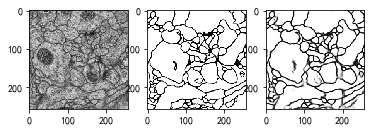

In [14]:
g_lst = []
r_lst = []
n_lst = []
for i in range(30):
    picture = str(i)+".png"
    picture2 =str(i)+"_predict.png"
    img_test_raw = tf.io.read_file(os.path.join("data/membrane/train/image/",picture))
    img_test = tf.image.decode_png(img_test_raw)
    img_test = tf.image.resize(img_test, (256,256))
    img_test = img_test /  255
    img_test = tf.reshape(img_test,(1,256,256,1))


    mask_test_raw = tf.io.read_file(os.path.join("data/membrane/train/label/",picture))
    mask_test = tf.image.decode_png(mask_test_raw)
    mask_test = tf.image.resize(mask_test, (256,256))
    mask_test = mask_test /  255
    mask_test = tf.reshape(mask_test,(1,256,256,1))
    
    
    gen_test_raw = tf.io.read_file(os.path.join("data/membrane/train/predict/",picture2))
    gen_test = tf.image.decode_png(gen_test_raw)
    gen_test = tf.image.resize(gen_test, (256,256))
    gen_test = gen_test /  255
    gen_test = tf.reshape(gen_test,(1,256,256,1))
    
    
    noise = tf.random.uniform([1,256,256,1])
    g_lst.append(discriminator.predict([img_test,mask_test]).max())
    r_lst.append(discriminator.predict([img_test,gen_test]).max())
    n_lst.append(discriminator.predict([img_test,noise]).max())
    plt.subplot(1,3,1)
    plt.imshow(img_test[0,:,:,0],cmap="gray")
    plt.subplot(1,3,2)
    plt.imshow(mask_test[0,:,:,0],cmap="gray")
    plt.subplot(1,3,3)
    plt.imshow(gen_test[0,:,:,0],cmap="gray")
    

    

In [15]:
np.average(g_lst)

0.63981235

In [16]:
np.average(r_lst)

0.6355507

In [17]:
np.average(n_lst)

0.28244168